### 1.) Import RL Book Code and Other Libraries

In [3]:
import sys
sys.path.insert(0, '/Users/spencersiegel/Documents/Stanford/Winter 2023/CME 241/RL-book/')
from typing import Callable, Sequence, Tuple, List
import numpy as np
import random
from scipy.stats import norm
import pandas as pd
from rl.function_approx import DNNApprox, LinearFunctionApprox, \
    FunctionApprox, DNNSpec, AdamGradient, Weights
from random import randrange
from numpy.polynomial.laguerre import lagval
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from random import randrange
import matplotlib.pyplot as plt
import numpy

### 2.) Create LSPI Algorithm

In [4]:
TrainingDataType = Tuple[float, float, float, float, float, float, 
                         float, float, float, float, float, float]

def fitted_lspi_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> LinearFunctionApprox:

    epsilon: float = 1e-3
    # Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
    #       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
    #       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
    #       'ScoreMarginxTimeRemainingInterval',
    #       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
    #       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    features = list(lambda x: x[i] for i in range(13))

    gamma: float = 1.0
    num_features: int = len(features) # will be hardcoded based on Spencer's code

    wts: np.ndarray = np.zeros(num_features)
    for _ in range(training_iters):
        a_inv: np.ndarray = np.eye(num_features) / epsilon
        b_vec: np.ndarray = np.zeros(num_features)
        cont: np.ndarray = np.dot(next_feature_vals, wts)
        cont_cond: np.ndarray = non_terminal * (cont > exer)
        for i in range(len(feature_vals)):
            phi1: np.ndarray = feature_vals[i]
            phi2: np.ndarray = phi1 - \
                cont_cond[i] * gamma * next_feature_vals[i]
            temp: np.ndarray = a_inv.T.dot(phi2)
            a_inv -= np.outer(a_inv.dot(phi1), temp) / (1 + phi1.dot(temp))
            b_vec += phi1 * (1 - cont_cond[i]) * exer[i] * gamma
        wts = a_inv.dot(b_vec)

    return LinearFunctionApprox.create(
        feature_functions=features,
        weights=Weights.create(wts)
    )


### 3.) Run LSPI Algorithm

In [9]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df_lspi = pd.read_csv('data/NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df_lspi = df_lspi.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df_lspi = df_lspi[df_lspi['RollingAvgPlayerPoints'] > 15]
names = df_lspi['Player']
opposition = df_lspi['Opponent']
date = df_lspi['Date']
game = df_lspi['GameId']
# drop date, player, gameid
feature_list = ['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
df_lspi = df_lspi[feature_list]
# drop rows with missing values
df_lspi = df_lspi.dropna()
# convert to numpy array
feature_vals = df_lspi.to_numpy()
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=100,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted LSPI Model")

res = np.matmul(feature_vals, flspi.weights.weights)
df_lspi['Player'] = names
df_lspi['res'] = res
df_lspi['Opposition'] = opposition
df_lspi['Date'] = date
df_lspi['Game'] = game
# save output to csv
df_lspi.to_csv('lspi_output.csv')
print('done')

Fitted LSPI Model
done


In [10]:
pd.Series(flspi.weights.weights, index=feature_list)

Interval                                  -2.290673
CumulativePlayerPointsInterval             0.428916
Home                                       0.034944
TeamRest                                  -0.030532
OpponentTeamRest                          -0.030532
CumulativeTeamPointsInterval              -0.007500
CumulativeOpponentPointsInterval          -0.004319
ScoreMarginInterval                       -0.003165
ScoreMarginxTimeRemainingInterval          0.003452
ScoreMarginxTimeRemaining2Interval        -0.000079
RollingAvgPlayerPoints                    -0.034004
RollingAverageOpposingTeamAllowedPoints    0.054988
RollingAverageTeamPoints                  -0.012414
dtype: float64

We see above the features and corresponding coefficients from the LSPI algorithm. One interesting takeaway is the fact that the interval has a large negative coefficient. This is sensible because the further into the game (start of 3rd and 4th quarter), there is more certainty about the number of points that a player will end up scoring by the game's end. This is similar to the idea that the value of an option decreases as we decrease the time to expiry. 

Another interesting coefficient is the RollingAverageOpposingTeamAllowedPoints which is a positive coefficient. When a player is facing an opponent who allows many points (poor defense), they are likely to score more than they typically do and therefore, this FlexPoints product should be valued highly. 

One of the strongest positive coefficients is the CumulativePlayerPointsInterval (how many points a player has scored so far in the game). This positive coefficient suggests that we value the price of the option more when the player has scored more. This coefficient suggests that future points (the value of continuing) are dependent on past performance in the current game. For instance, if a player gets off to a hot start and is scoring a lot, we expect this trend to continue and vice-versa. 

One other interesting in-game feature is the ScoreMarginInterval feature. While we use absolute value of score margin for the interactions with TimeRemaining, the ScoreMarginInterval represents the score from the view of the player's team (positive when team is leading, negative when team is trailing).This feature has a negative coefficient which suggests that the FlexPoints value has a negative relationship with score margin. This seems unintuitive but in fact, this is a popular phenomenon in basketball analytics commonly referred to as the 'rubber band effect' whereby the team leading tends to take their foot off the gas and allow the other team to come back. Therefore, we expect more scoring by the trailing team in these scenarios. This could explain the negative coefficient that we see on ScoreMarginInterval since it suggests that we expect the player (and his team) to score more when trailing. I have shown a plot of the 'rubber band effect' from the 2020 NBA season as shown by Nathan Walker (@bbstats on twitter)

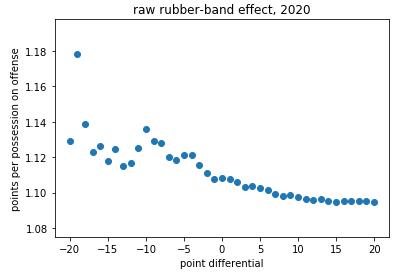

### 4.) Create DQL Algorithm

In [4]:
class DQN_model(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.layer1 = nn.Linear(num_features, 15)
        self.layer2 = nn.Linear(15, 15)
        self.layer3 = nn.Linear(15, 1)

        # Initialize the linear layers
        nn.init.uniform_(self.layer1.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer2.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer3.weight, a = -0.1, b = 0.1)
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        
    def forward(self, x):
        x2 = F.softplus(self.layer1(x))
        x3 = F.softplus(self.layer2(x2))
        return self.layer3(x3)
    
    def forward_in_batches(self, x):
        with torch.no_grad():
            batch_size = 100
            num_batches = int(np.ceil(x.shape[0] / batch_size))
            y = []
            for i in range(num_batches):
                y.append(self.forward(x[i * batch_size: min((i + 1) * batch_size, x.shape[0])]))
            return torch.cat(y)

def fitted_dql_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> torch.nn.Module:
    
    model = DQN_model(num_features=13)
    features_vals = torch.tensor(feature_vals, dtype=torch.float)
    next_feature_vals = torch.tensor(next_feature_vals, dtype=torch.float)

    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    alpha = 0.003

    for _ in tqdm(range(training_iters), desc="Epochs"):
        i = randrange(len(feature_vals))
        q_score = model(features_vals[i])
        q_score_next = model(next_feature_vals[i])
        grad = torch.autograd.grad(q_score, model.parameters())
        with torch.no_grad():
            if non_terminal[i]:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (max(exer[i], q_score_next)-q_score) * g)
            else:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (exer[i]-q_score) * g)
                    
        alpha = max(alpha * 0.999, .00001) # decay learning rate
        model.zero_grad()  # reset gradients
    
    return model

### 5.) Run DQL Algorithm

Epochs: 100%|█████████████████████████| 500000/500000 [03:39<00:00, 2276.99it/s]


Fitted DQL Model
done


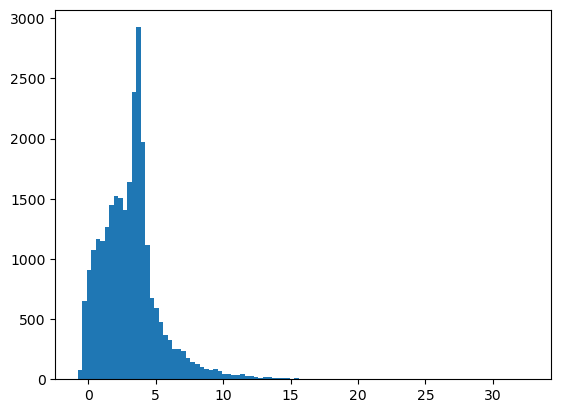

In [5]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df_dqn = pd.read_csv('NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df_dqn = df_dqn.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df_dqn = df_dqn[df_dqn['RollingAvgPlayerPoints'] > 15]
names = df_dqn['Player']
# drop date, player, gameid
df_dqn = df_dqn[['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']]
# drop rows with missing values
df_dqn = df_dqn.dropna()
# convert to numpy array
feature_vals = df_dqn.to_numpy()

# Standardize the columns of the data except for those used in exer
means_vec = np.mean(feature_vals, axis=0)
std_vec = np.std(feature_vals, axis=0)
means_vec[0] = 0
std_vec[0] = 1
means_vec[1] = 0
std_vec[1] = 1
means_vec[10] = 0
std_vec[10] = 1
feature_vals = (feature_vals - means_vec) / std_vec
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

fldq: torch.nn.Module = fitted_dql_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=500000,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted DQL Model")

res_dqn = fldq.forward_in_batches(torch.tensor(feature_vals, dtype=torch.float))
# convert res to numpy array from torch tensor
res_dqn = res_dqn.numpy()
# make a histogram using res
plt.hist(res_dqn, bins=100)

df_dqn['Player'] = names
df_dqn['res'] = res_dqn
df_dqn.to_csv('dqn_nba_output.csv')
print('done')

### 6.) Plot Points Development as Demo

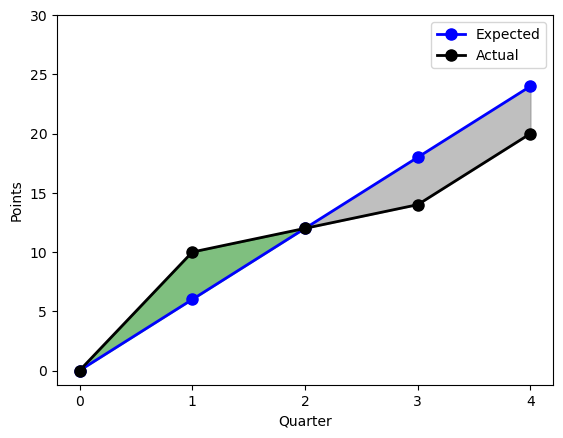

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the expected and actual scores
expected_points = np.array([0, 6, 12, 18, 24])
actual_points = np.array([0, 10, 12, 14, 20])

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points >= expected_points), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set the title and legend
#ax.set_title('Payout Over Time')
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks([0, 5, 10, 15, 20, 25, 30])

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels([0, 5, 10, 15, 20, 25, 30])

# Display the plot
plt.savefig('example_full.png', transparent = True)
plt.show()



### 7.) Real Example from Data Using LSPI

89420    4.176361
340      3.825284
22610    5.383903
44880    5.046337
67150    2.073636
Name: res, dtype: float64
[0.  0.5 5.  6.5 2. ]


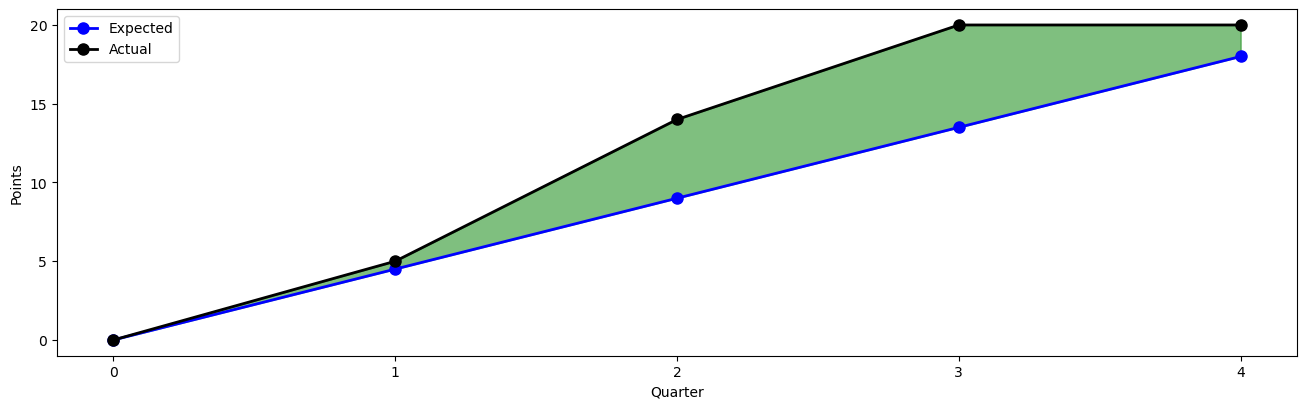

In [7]:
# Get the data for Steph Curry vs the Nuggets
df_ad_lspi = df_lspi[df_lspi['Player'] == 'A. Davis - davisan02']
df_ad_lspi = df_ad_lspi[df_ad_lspi['Game'] == 566]
expected_points = np.array([0, 4.5, 9, 13.5, 18])
actual_points = np.array([0, 5, 14, 20, 20])

print(df_ad_lspi['res'])

payoff = actual_points - expected_points
print(payoff)

# Payoff plot
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points >= expected_points), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set title and legend
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks(np.arange(0, max(actual_points) + 5, 5))

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels(np.arange(0, max(actual_points) + 5, 5))

# Display the plot
fig.set_figheight(4.5)
fig.set_figwidth(16)
plt.savefig('example_old.png', transparent = True)
plt.show()

### Example from this week: Warriors vs Suns

In [51]:
# STATS for klay leading up to game:
data_klay = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 20, 112.4, 116.2]
#STATS for steph leading up to game:
data_steph = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 30, 112.4, 116.2]
# normalize
data_klay = (data_klay - means_vec) / std_vec
data_steph = (data_steph - means_vec) / std_vec

# opt price at start
price_klay = fldq.forward_in_batches(torch.tensor(data_klay, dtype=torch.float))
price_steph = fldq.forward_in_batches(torch.tensor(data_steph, dtype=torch.float))
print('Initial Flexpoints price for klay: ' + str(price_klay))
print('Initial Flexpoints price for steph: ' + str(price_steph))

# calculate optimal policy at quarters 1-3:
data_0_klay = [0, 18, 1, 1, 0, 0, 0, 0, 0, 0, 20, 112.4, 116.2]
data_1_klay = [1, 33, 1, 1, 0, 43, 21, 22, 792, 28512, 20, 112.4, 116.2]
data_2_klay = [2, 33, 1, 1, 0, 75, 58, 17, 408, 9792, 20, 112.4, 116.2]
data_3_klay = [3, 38, 1, 1, 0, 98, 88, 10, 120, 1440, 20, 112.4, 116.2]

data_0_steph = [0, 12, 1, 1, 0, 0, 0, 0, 0, 0, 30.6, 112.4, 116.2]
data_1_steph = [1, 15, 1, 1, 0, 43, 21, 22, 792, 28512, 30, 112.4, 116.2]
data_2_steph = [2, 20, 1, 1, 0, 75, 58, 17, 408, 9792, 30, 112.4, 116.2]
data_3_steph = [3, 23, 1, 1, 0, 98, 88, 10, 120, 1440, 30, 112.4, 116.2]
# normalize
data_1_klay = (data_1_klay - means_vec) / std_vec
data_2_klay = (data_2_klay - means_vec) / std_vec
data_3_klay = (data_3_klay - means_vec) / std_vec
data_1_steph = (data_1_steph - means_vec) / std_vec
data_2_steph = (data_2_steph - means_vec) / std_vec
data_3_steph = (data_3_steph - means_vec) / std_vec


price_1_steph = fldq.forward_in_batches(torch.tensor(data_1_steph, dtype=torch.float))
price_2_steph = fldq.forward_in_batches(torch.tensor(data_2_steph, dtype=torch.float))
price_3_steph = fldq.forward_in_batches(torch.tensor(data_3_steph, dtype=torch.float))
price_1_klay = fldq.forward_in_batches(torch.tensor(data_1_klay, dtype=torch.float))
price_2_klay = fldq.forward_in_batches(torch.tensor(data_2_klay, dtype=torch.float))
price_3_klay = fldq.forward_in_batches(torch.tensor(data_3_klay, dtype=torch.float))


print('Val of continue at end of quarter 1 klay: ' + str(price_1_klay))
print('Val of continue at end of quarter 2 klay: ' + str(price_2_klay))
print('Val of continue at end of quarter 3 klay: ' + str(price_3_klay))

print('Val of continue at end of quarter 1 steph: ' + str(price_1_steph))
print('Val of continue at end of quarter 2 steph: ' + str(price_2_steph))
print('Val of continue at end of quarter 3 steph: ' + str(price_3_steph))

Initial Flexpoints price for klay: tensor([3.5586])
Initial Flexpoints price for steph: tensor([3.5148])
Val of continue at end of quarter 1 klay: tensor([27.4478])
Val of continue at end of quarter 2 klay: tensor([20.6918])
Val of continue at end of quarter 3 klay: tensor([21.1864])
Val of continue at end of quarter 1 steph: tensor([7.8753])
Val of continue at end of quarter 2 steph: tensor([6.1075])
Val of continue at end of quarter 3 steph: tensor([3.9165])


### 8.) Generate Plot for Example

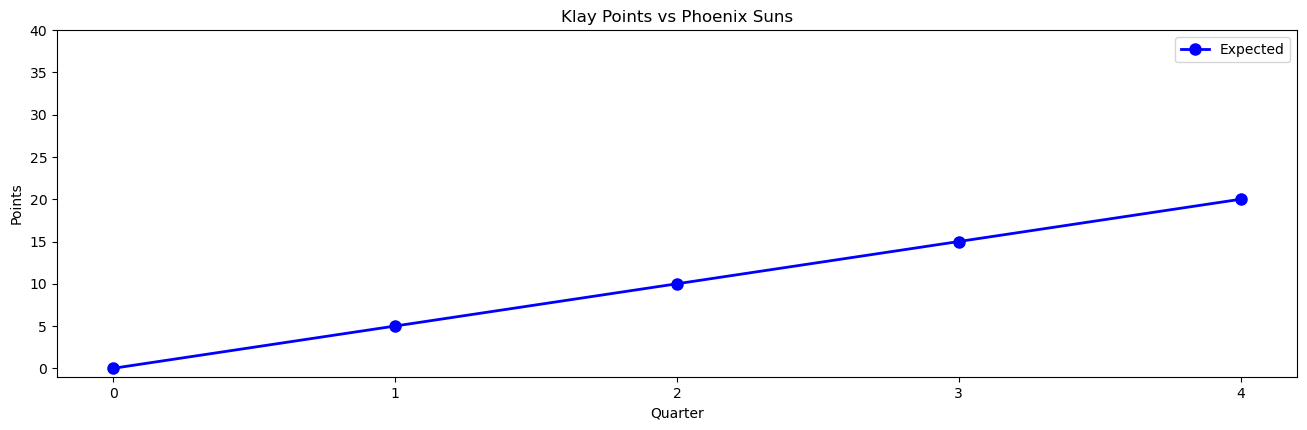

In [64]:
expected_points = np.array([0, 5, 10, 15, 20])
expected_points_q = np.array([0, 5, 10, 15, 20])
actual_points = np.array([18, 33, 33, 38])

# Payoff plot
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(expected_points_q, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points_q)), expected_points_q, actual_points,
                where=(actual_points >= expected_points_q), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
#ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
#                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set the title and legend
ax.set_title('Klay Points vs Phoenix Suns')
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks([0,5,10,15,20,25,30,35,40])

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels([0,5,10,15,20,25,30,35,40])

# Display the plot
fig.set_figheight(4.5)
fig.set_figwidth(16)
plt.savefig('example_inclass_final.png', transparent = True)
plt.show()

In [119]:
payoff = actual_points - expected_points
print(payoff)

[ 0.    8.55 14.1  17.65 15.2 ]
